In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            roc_auc_score, precision_recall_curve, accuracy_score,
                            f1_score, recall_score, precision_score)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB
None

First 5 rows:
   UserID CourseCategory  TimeSpentOnCourse  NumberOfVideosWatched  \
0    5618         Health          29.979719                     17   
1    4326           Arts          27.802640                      1   
2    5849     

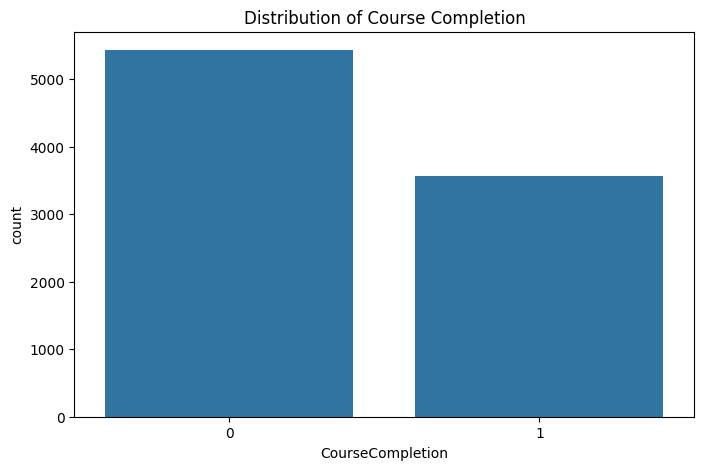

In [63]:
df = pd.read_csv('online_course_engagement_data.csv')

# Data Exploration
print("Dataset Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())
print("\nDescriptive Statistics:")
print(df.describe())
print("\nMissing Values:")
print(df.isnull().sum())

# Visualize target distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='CourseCompletion', data=df)
plt.title('Distribution of Course Completion')
plt.show()

In [64]:
# Feature engineering
df['EngagementScore'] = (df['NumberOfVideosWatched'] * df['TimeSpentOnCourse']) / (df['NumberOfQuizzesTaken'] + 1)
df['ProgressConsistency'] = df['NumberOfQuizzesTaken'] / (df['TimeSpentOnCourse'] / 7)  # Quizzes per week

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df, columns=['CourseCategory', 'DeviceType'], drop_first=True)

display(df_encoded[['EngagementScore', 'ProgressConsistency']].describe())

,EngagementScore,ProgressConsistency
count,9000.000000,9000.000000
mean,136.042287,1.725181
std,208.911927,4.182886
min,0.000000,0.000000
25%,22.517353,0.323298
50%,67.372961,0.708848
75%,157.155470,1.402075
max,1920.674412,67.323691


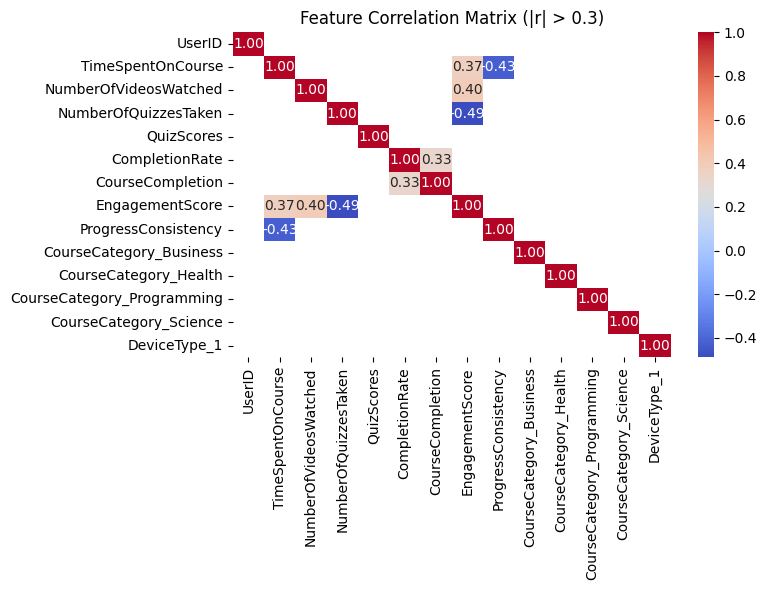

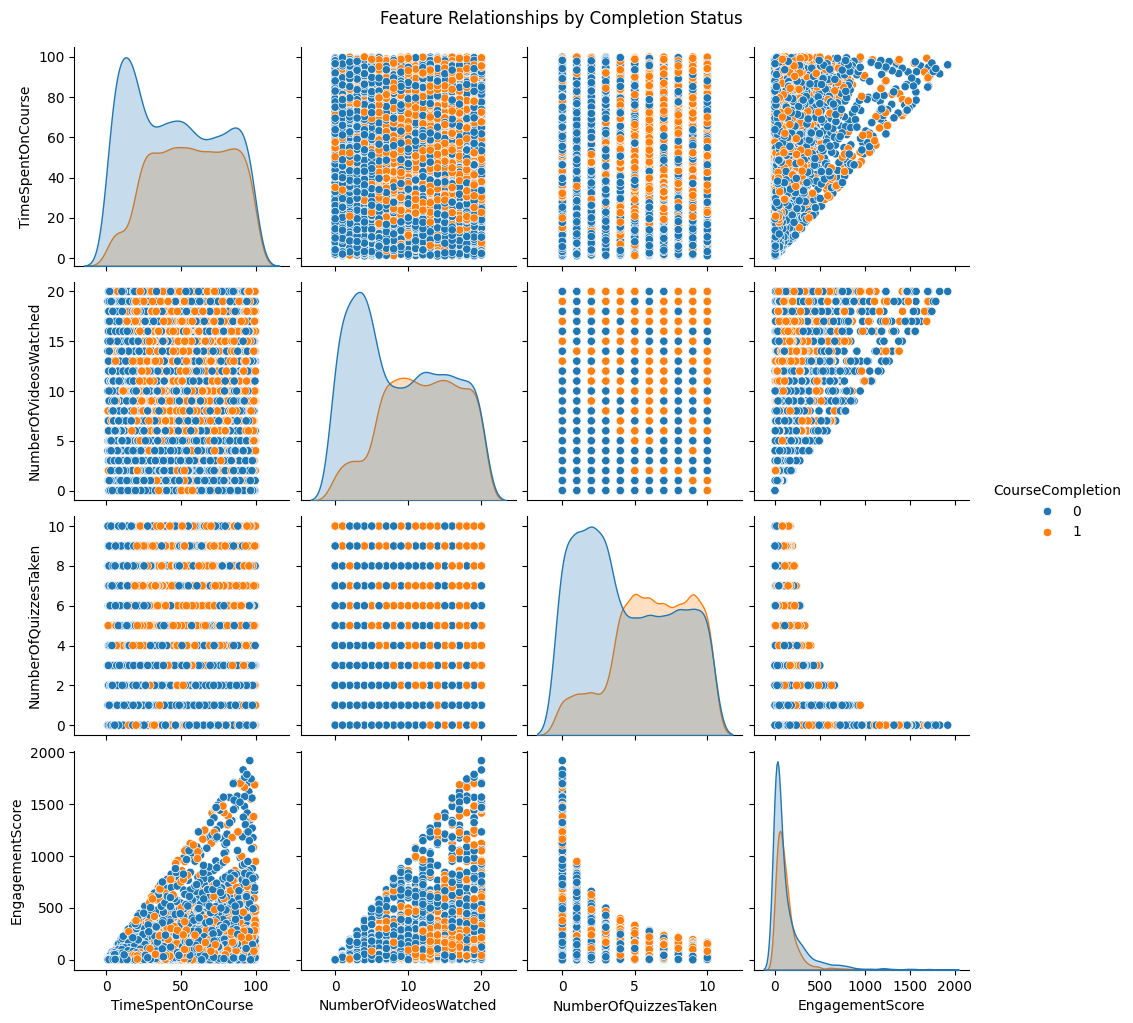

In [65]:
# Data Visualization
# Correlation matrix 
plt.figure(figsize=(8, 6))
corr_matrix = df_encoded.corr()
mask = (corr_matrix >= 0.3) | (corr_matrix <= -0.3)
sns.heatmap(corr_matrix[mask], annot=True, cmap='coolwarm', fmt=".2f", mask=~mask)
plt.title('Feature Correlation Matrix (|r| > 0.3)')
plt.tight_layout()
plt.show()

# Pairplot of key features
sns.pairplot(df_encoded[['TimeSpentOnCourse', 'NumberOfVideosWatched', 
                         'NumberOfQuizzesTaken', 'EngagementScore', 
                         'CourseCompletion']], hue='CourseCompletion')
plt.suptitle('Feature Relationships by Completion Status', y=1.02)
plt.show()

In [66]:
#Data modeling
# Split features and target
X = df_encoded.drop(['UserID', 'CourseCompletion'], axis=1)
y = df_encoded['CourseCompletion']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Scale numerical features
scaler = StandardScaler()
num_cols = ['TimeSpentOnCourse', 'NumberOfVideosWatched', 
            'NumberOfQuizzesTaken', 'QuizScores', 
            'EngagementScore', 'ProgressConsistency']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (7200, 12)
Test set shape: (1800, 12)


In [67]:
# Model evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision)
    plt.title(f'{model.__class__.__name__} Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    
    return metrics

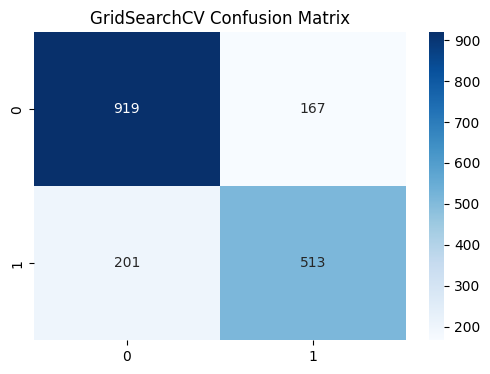

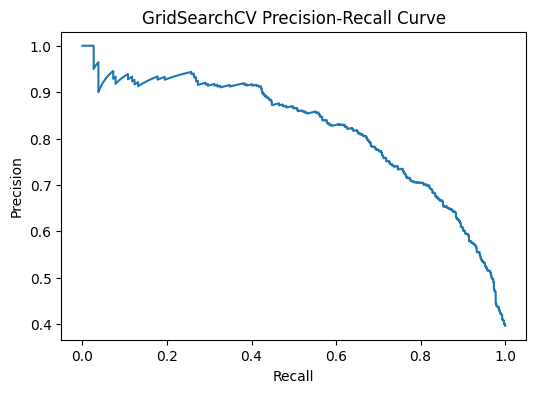

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}


,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.795556,0.754412,0.718487,0.736011,0.868694


In [68]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1', n_jobs=-1)
lr_metrics = evaluate_model(grid_lr, X_train, y_train, X_test, y_test)

print("Best Parameters:", grid_lr.best_params_)
pd.DataFrame([lr_metrics], index=['Logistic Regression'])

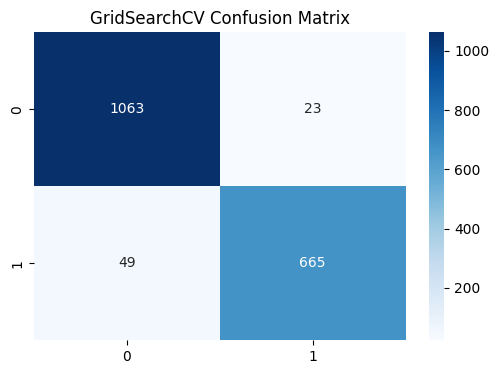

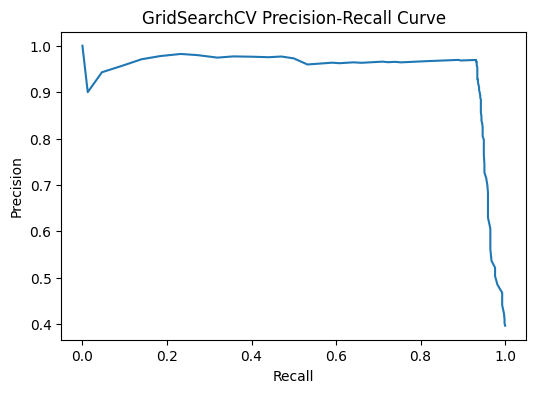

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


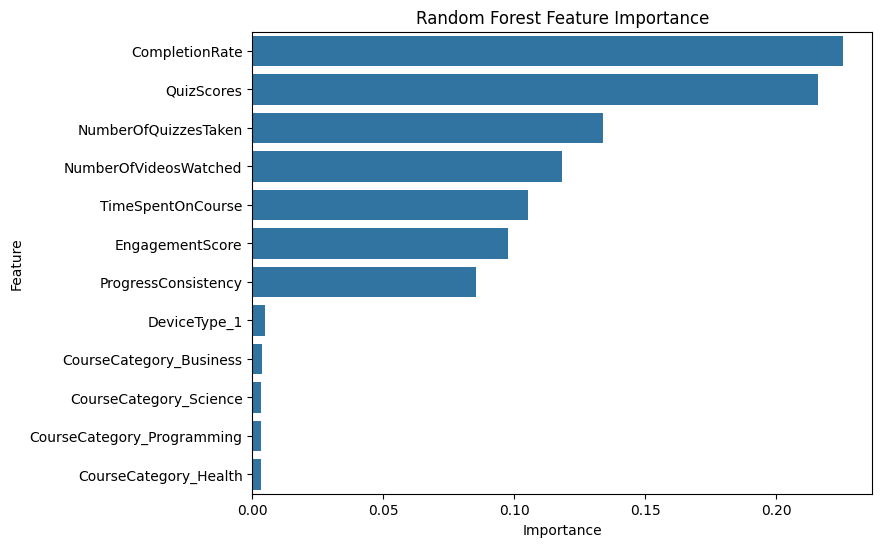

,Accuracy,Precision,Recall,F1,ROC AUC
Random Forest,0.96,0.96657,0.931373,0.948645,0.960276


In [69]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='f1', n_jobs=-1)
rf_metrics = evaluate_model(grid_rf, X_train, y_train, X_test, y_test)

print("Best Parameters:", grid_rf.best_params_)

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': grid_rf.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Random Forest Feature Importance')
plt.show()

pd.DataFrame([rf_metrics], index=['Random Forest'])

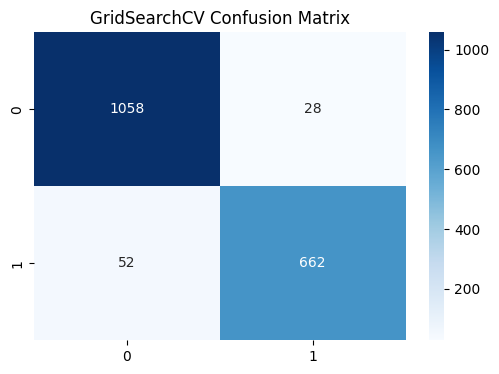

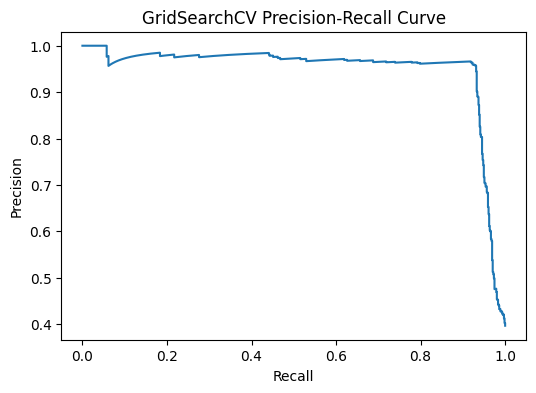

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


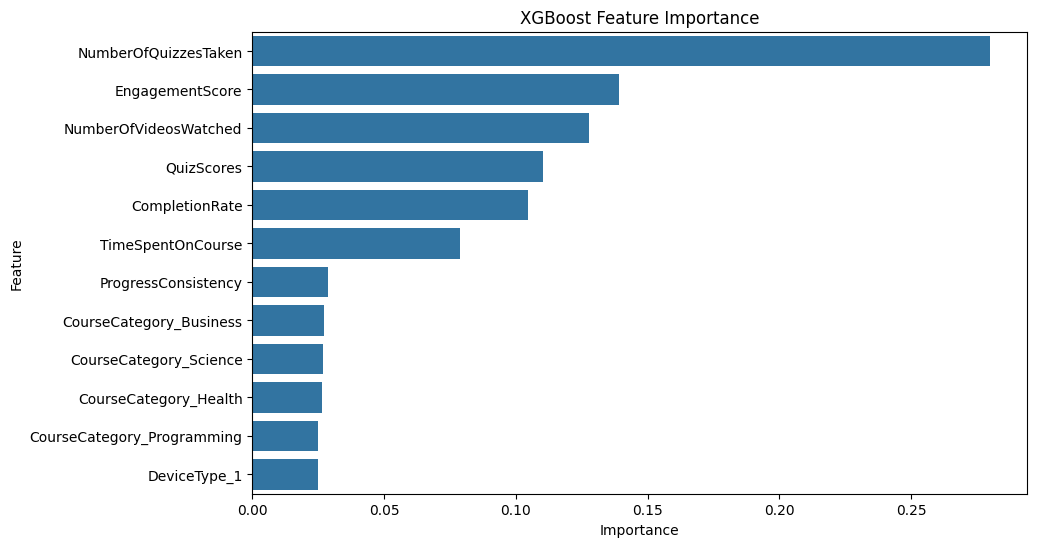

,Accuracy,Precision,Recall,F1,ROC AUC
XGBoost,0.955556,0.95942,0.927171,0.94302,0.957706


In [70]:
# XGBoost
xgb = XGBClassifier(random_state=42, eval_metric='logloss')
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, scoring='f1', n_jobs=-1)
xgb_metrics = evaluate_model(grid_xgb, X_train, y_train, X_test, y_test)

print("Best Parameters:", grid_xgb.best_params_)

# Feature Importance
xgb_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': grid_xgb.best_estimator_.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=xgb_importance)
plt.title('XGBoost Feature Importance')
plt.show()

pd.DataFrame([xgb_metrics], index=['XGBoost'])

,Accuracy,Precision,Recall,F1,ROC AUC
Logistic Regression,0.795556,0.754412,0.718487,0.736011,0.868694
Random Forest,0.960000,0.966570,0.931373,0.948645,0.960276
XGBoost,0.955556,0.959420,0.927171,0.943020,0.957706


<Figure size 1200x600 with 0 Axes>

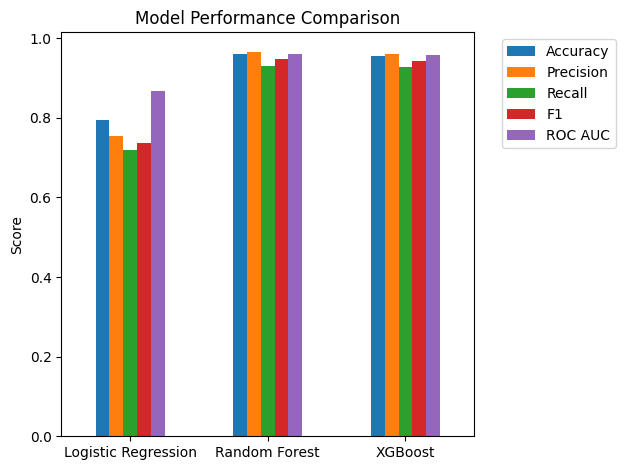


Best performing model based on F1 score: Random Forest


In [71]:
# Model comparision
results = pd.DataFrame([lr_metrics, rf_metrics, xgb_metrics], 
                      index=['Logistic Regression', 'Random Forest', 'XGBoost'])

display(results)

plt.figure(figsize=(12, 6))
results.plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

best_model = results['F1'].idxmax()
print(f"\nBest performing model based on F1 score: {best_model}")